In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import ClusterCentroids
import numpy as np

# Part 2: Data Preparation 

In [18]:
df = pd.read_csv("cleaned_ebay_deals.csv")

df['price'] = df['price'].dropna()
df['original_price'] = df['original_price'].dropna()
df['shipping'] = df['shipping'].dropna()
df['discount_percentage'] = df['discount_percentage'].dropna()
df['shipping'] = df['shipping'].replace({
    "Free shipping": 0,
    "Shipping info unavailable": 0
})
print(df.head())

             timestamp                                              title  \
0  2025-03-19 06:28:22  Klipsch R-120SWi 12" High-Performance Wireless...   
1  2025-03-19 06:28:22  Apple iPhone 14 Pro Max 128GB Network Unlocked...   
2  2025-03-19 06:28:22  Apple iPhone 14 Pro Max 256GB Unlocked Very Go...   
3  2025-03-19 06:28:22  Apple iPhone 14 Pro A2650 128GB Network Unlock...   
4  2025-03-19 06:28:22  Apple iPhone 14 128GB Network Unlocked Very Go...   

    price  original_price  shipping  \
0  159.99          179.99         0   
1  499.99         1099.00         0   
2  549.99         1199.00         0   
3  414.99          899.00         0   
4  305.99          749.00         0   

                                                 url  discount_percentage  
0  https://www.ebay.com/itm/365374754988?_trkparm...                11.11  
1  https://www.ebay.com/itm/365374754988?_trkparm...                54.51  
2  https://www.ebay.com/itm/365374754988?_trkparm...                54.13 

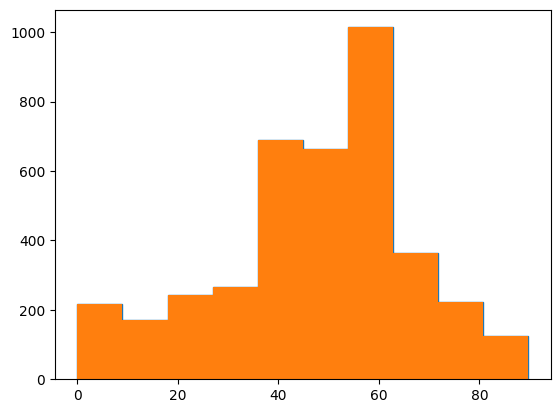

In [19]:
counts, bins = np.histogram(df['discount_percentage'])
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

# Part 3: Binning and Balancing the Dataset 

In [20]:
def bin_discount(discount):
    if(discount<=10):
        return "Low"
    elif ((discount>10) & (discount<=30)):
        return "Medium"
    else:
        return "High"

df['discount_bin'] = df['discount_percentage'].apply(bin_discount)

print(df.head())

             timestamp                                              title  \
0  2025-03-19 06:28:22  Klipsch R-120SWi 12" High-Performance Wireless...   
1  2025-03-19 06:28:22  Apple iPhone 14 Pro Max 128GB Network Unlocked...   
2  2025-03-19 06:28:22  Apple iPhone 14 Pro Max 256GB Unlocked Very Go...   
3  2025-03-19 06:28:22  Apple iPhone 14 Pro A2650 128GB Network Unlock...   
4  2025-03-19 06:28:22  Apple iPhone 14 128GB Network Unlocked Very Go...   

    price  original_price  shipping  \
0  159.99          179.99         0   
1  499.99         1099.00         0   
2  549.99         1199.00         0   
3  414.99          899.00         0   
4  305.99          749.00         0   

                                                 url  discount_percentage  \
0  https://www.ebay.com/itm/365374754988?_trkparm...                11.11   
1  https://www.ebay.com/itm/365374754988?_trkparm...                54.51   
2  https://www.ebay.com/itm/365374754988?_trkparm...                54.

In [21]:
# Count the initial distribution of discount bins
count_of_discount_bins = df['discount_bin'].value_counts()
print("\nInitial Discount Bin Counts:\n", count_of_discount_bins)

# Prepare features (X) and target (y) for undersampling
X = df[['price', 'original_price', 'shipping', 'discount_percentage']]
y = df['discount_bin']

# Initialize and apply ClusterCentroids undersampling
cc = ClusterCentroids(random_state=42)
X_resampled, y_resampled = cc.fit_resample(X, y)

# Create a new DataFrame from the resampled data
df = pd.DataFrame(X_resampled, columns=X.columns)
df['discount_bin'] = y_resampled

# Print the head of the resampled DataFrame and the new counts
print("\nResampled DataFrame Head:\n", df.head())
print("\nResampled Discount Bin Counts:\n", df['discount_bin'].value_counts())


Initial Discount Bin Counts:
 discount_bin
High      3226
Medium     488
Low        261
Name: count, dtype: int64

Resampled DataFrame Head:
          price  original_price  shipping  discount_percentage discount_bin
0   748.974107     1199.797321         0            37.574464         High
1  1359.000000     3099.000000         0            56.150000         High
2   275.990000      499.990000         0            44.800000         High
3   809.375000     1999.928125         0            59.530000         High
4  2529.000000     4599.000000         0            45.010000         High

Resampled Discount Bin Counts:
 discount_bin
High      261
Low       261
Medium    261
Name: count, dtype: int64


c:\Users\danad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (80) found smaller than n_clusters (261). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [22]:
df = df.drop(columns=['discount_bin'])
print(df.head())

         price  original_price  shipping  discount_percentage
0   748.974107     1199.797321         0            37.574464
1  1359.000000     3099.000000         0            56.150000
2   275.990000      499.990000         0            44.800000
3   809.375000     1999.928125         0            59.530000
4  2529.000000     4599.000000         0            45.010000


# Part 4: Regression Modeling

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

X = df[['price', 'original_price', 'shipping']]
y = df['discount_percentage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results = pd.DataFrame([{"MSE": mse, "MAE": mae, "RMSE": rmse, "Coefficient of Determination": r2}])
results

,MSE,MAE,RMSE,Coefficient of Determination
0,308.50356,13.052981,17.564269,0.828977


# Part 5: Visual Evaluation

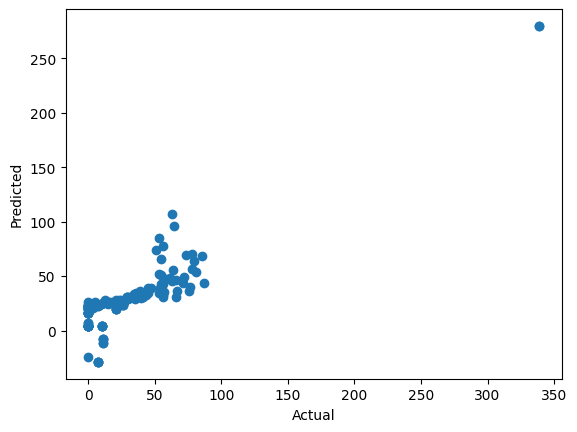

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

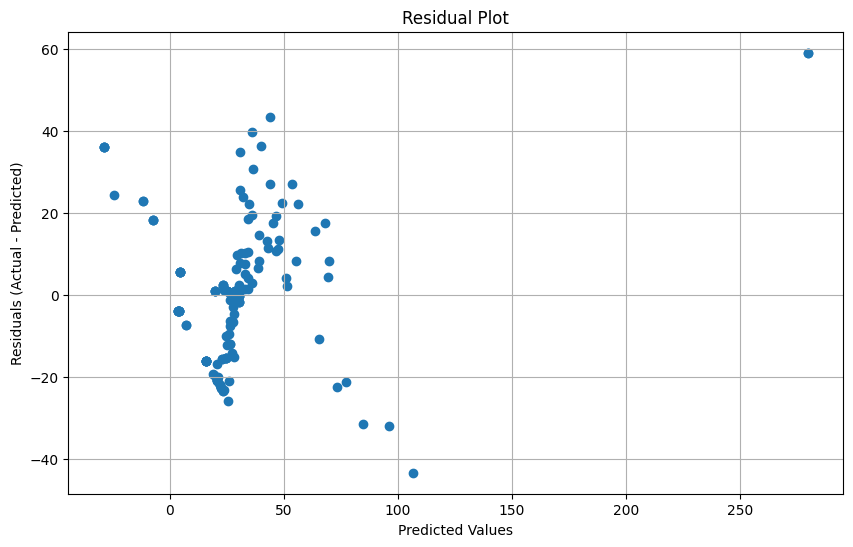

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
# plt.axhline(y=0, color='r', linestyle='--')  
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Part 6: Applying the Model to Incomplete Data 

In [27]:

df_copy = df.drop(["discount_percentage"], axis=1, errors='ignore')
print(df_copy.columns)
relevent_data = df_copy.sample(20)
relevent_data = relevent_data[['price', 'original_price', 'shipping']]
print(relevent_data)

Index(['price', 'original_price', 'shipping'], dtype='object')
           price  original_price  shipping
760   147.990000      199.990000         0
627  2519.000000     3406.990000         0
619  2519.000000     3406.990000         0
99    879.990000     1342.990000         0
526 -9038.429283    -7378.220799         0
3     809.375000     1999.928125         0
442   236.990000      238.990000         0
690  1499.000000     1899.000000         0
158   799.990000     1499.000000         0
367   649.990000      649.990000         0
28   1898.000000     3077.200000         0
776  1499.000000     1899.000000         0
734  2809.000000     3149.000000         0
21     37.490000       59.990000         0
185   601.039388      999.038776         0
22   1138.000000     3199.950000         0
141   245.677273     1299.990000         0
757  2809.000000     3149.000000         0
345   599.990000      599.990000         0
78    604.156667     1299.000000         0


In [28]:
relevent_data["predicted_discount"] = model.predict(relevent_data[['price', 'original_price', 'shipping']])
relevent_data

,price,original_price,shipping,predicted_discount
760,147.990000,199.990000,0,28.127492
627,2519.000000,3406.990000,0,25.169445
619,2519.000000,3406.990000,0,25.169445
99,879.990000,1342.990000,0,34.790752
526,-9038.429283,-7378.220799,0,279.769583
3,809.375000,1999.928125,0,72.162947
442,236.990000,238.990000,0,23.984045
690,1499.000000,1899.000000,0,20.082214
158,799.990000,1499.000000,0,47.982564
367,649.990000,649.990000,0,16.154246
